#### **Imports**

In [1]:
import pandas as pd
import numpy as np
import requests
import time
import nltk
import regex as re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
import warnings 
warnings.filterwarnings("ignore")

#### **Read in .csv file and remove first column**

In [2]:
# read in dataframe saved as .csv file
df = pd.read_csv('comments.csv')
# drop first column
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,author,body,score,created_utc,subreddit
0,RobusEtCeleritas,None of that means anything You clearly have ...,3,1627142891,1
1,hydroxypcp,The legal limit varies among countries It s c...,0,1627140964,1
2,AnthillOmbudsman,But magma chambers aren t hollow caverns I m...,1,1627140360,1
3,AWormDude,According to this study https www research...,5,1627139388,1
4,Trypanosoma_,Look up TH cellular response vs TH humora...,-4,1627136260,1


In [ ]:
all_stop_words = stopwords.words('english')
new_words=('https', 'com', 'www', 'really', 'would', 'gt', 'like', 'also', 'get', 'even', 'much', 'could', 'see', 'really', 'know')
for i in new_words:
    all_stop_words.append(i)

#### **X, y, train_test_split**

In [3]:
X = df[['body']]
y = df['subreddit']

X = [word.lower().split() for word in df['body']]
stops = set(stopwords.words('english'))
posts_list = []
for post in X:
    meaningful_words = [word for word in post if word not in all_stop_words]
    meaningful_post = " ".join(meaningful_words)
    posts_list.append(meaningful_post)
    
modeltext = pd.Series(posts_list)
df['body'] = modeltext
X = df['body']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,
                                   y,
                                   train_size=0.75,
                                   stratify=y,
                                   random_state=42)

### **Baseline Accuracy**

In [4]:
y.value_counts(normalize=True)

0    0.699791
1    0.300209
Name: subreddit, dtype: float64

#### **Random Forest & GridSearch**

In [8]:
%%time
rf_pipe = Pipeline([
    ('cv', CountVectorizer(min_df=3, max_df=.85, max_features=10000)),
    ('rf', RandomForestClassifier())
]
)

rf_params = {
#     'rf__bootstrap'       : [True, False],
    'rf__n_estimators' : [1000, 2000],
    'rf__max_depth'  : [500]
}

rf_gs = GridSearchCV(rf_pipe, rf_params, cv=5, verbose=1, n_jobs = -1)
rf_gs.fit(X_train, y_train)
print(rf_gs.best_params_)
print(rf_gs.score(X_train, y_train))
print(rf_gs.score(X_test, y_test))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'rf__max_depth': 500, 'rf__n_estimators': 1000}
0.981102159753171
0.8561511762437332
Wall time: 33min 48s


##### **Accuracy Score**

In [11]:
predictions_rf = rf_gs.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test, predictions_rf)}')

Accuracy Score: 0.8561511762437332


#### **Random Forest and RandomizedSearch**

In [9]:
%%time
pipe_rfc = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=10_000)),
    ('rfc', RandomForestClassifier())
]
)

params_rfc = {
#     'cv__max_features':[5_000],
#     'cv__min_df'      : [2, 5],
#     'cv__max_df'      : [.85, .90],
#     'cv__ngram_range' : [(1,1), (1,2)],
#     'rfc__bootstrap'       : [True, False],
    'rfc__n_estimators' : [500, 600],
    'rfc__max_depth'  : [100, 200, 300]
}

rs_rfc = RandomizedSearchCV(pipe_rfc, params_rfc, cv=5, verbose=1, n_jobs = -1)
rs_rfc.fit(X_train, y_train)
print(rs_rfc.best_params_)
print(rs_rfc.score(X_train, y_train))
print(rs_rfc.score(X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'rfc__n_estimators': 500, 'rfc__max_depth': 300}
0.956504970860473
0.8530659467797918
Wall time: 15min 13s


##### **Accuracy Score**

In [10]:
predictions_rfc = rs_rfc.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test, predictions_rfc)}')

Accuracy Score: 0.8530659467797918


#### **Confusion Matrix: Random Forest & RandomizedSearchCV**

Specificity: 0.9581190301249082


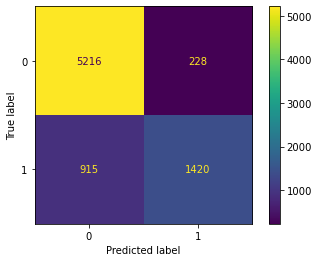

In [14]:
cm = confusion_matrix(y_test, predictions_rfc)
tn, fp, fn, tp = cm.ravel()

# Calculate specificity
spec = tn / (tn + fp)

print('Specificity:', spec)
ConfusionMatrixDisplay(cm).plot();